In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import KernelDensity
from shapely.wkt import loads
from shapely.geometry import shape, Point
import urllib.request, json
import requests
import urllib.parse
import os

import warnings
warnings.filterwarnings('ignore')


/Users/lizjohnson/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(
/var/folders/9f/7xdrpjw15kn4wccwzb5xhr0m0000gn/T/ipykernel_71232/3744263940.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to S

In [2]:
camera_locs = pd.read_csv('../Data/aggregated_camera_locs.csv',index_col = 0)
camera_locs['geometry'] = camera_locs['geometry'].apply(loads)
camera_locs = gpd.GeoDataFrame(camera_locs,geometry = 'geometry', crs = '4326')
camera_locs.head()

,Data_Source,Camera_Count,geometry,x,y
0,Amnesty,5,POINT (-73.95673 40.69289),-73.956733,40.692888
1,Amnesty,5,POINT (-73.97285 40.62937),-73.972852,40.629372
2,Amnesty,1,POINT (-73.96565 40.70615),-73.965655,40.706149
3,Amnesty,7,POINT (-73.90359 40.67201),-73.903590,40.672012
4,Amnesty,1,POINT (-73.95976 40.67575),-73.959759,40.675751


In [3]:
building_gdf = gpd.read_file('../Data/bk_building_block_boundary/bk_building_block_boundary.shp')
building_gdf.head()

,index,geometry
0,20.0,"POLYGON ((-73.98473 40.70375, -73.98595 40.703..."
1,30.0,"POLYGON ((-73.98694 40.70317, -73.98717 40.703..."
2,34.0,"POLYGON ((-73.98033 40.70311, -73.98075 40.703..."
3,35.0,"POLYGON ((-73.99323 40.70255, -73.99325 40.702..."
4,42.0,"POLYGON ((-73.98292 40.70237, -73.98433 40.702..."


In [4]:
building_gdf = building_gdf.rename(columns = {'index':'Block'})
building_gdf.columns

Index(['Block', 'geometry'], dtype='object')

In [5]:
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry.head()

,FID,geometry
0,0,"MULTIPOLYGON (((-74.00198 40.56960, -74.00209 ..."


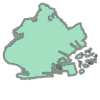

In [6]:
bk_bndry.geometry.values[0]

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.datasets import fetch_species_distributions
# from sklearn.neighbors import KernelDensity

# # if basemap is available, we'll use it.
# # otherwise, we'll improvise later...
# # try:
# #     from mpl_toolkits.basemap import Basemap

# #     basemap = True
# # except ImportError:
# #     basemap = False


# def construct_grids(camera_gdf):
#     """Construct the map grid from the batch object

#     Parameters
#     ----------
#     batch : Batch object
#         The object returned by :func:`fetch_species_distributions`

#     Returns
#     -------
#     (xgrid, ygrid) : 1-D arrays
#         The grid corresponding to the values in batch.coverages
#     """
#     # x,y coordinates for corner cells
#     minx, miny, maxx, maxy = camera_gdf.total_bounds
#     grid_size = 0.05
#     Nx = len(camera_gdf['x'].unique())
#     Ny = len(camera_gdf['y'].unique())
    
#     xmin = minx + grid_size
#     xmax = minx + (Nx * grid_size)
#     ymin = miny + grid_size
#     ymax = miny + (Ny * grid_size)

#     # x coordinates of the grid cells
#     xgrid = np.arange(xmin, xmax, grid_size)
#     # y coordinates of the grid cells
#     ygrid = np.arange(ymin, ymax, grid_size)

#     return (xgrid, ygrid)


# # Get matrices/arrays of species IDs and locations
# data = fetch_species_distributions()
# species_names = ["Bradypus Variegatus", "Microryzomys Minutus"]
# Xtrain = np.vstack([data["train"]["dd lat"], data["train"]["dd long"]]).T
# ytrain = np.array(
#     [d.decode("ascii").startswith("micro") for d in data["train"]["species"]],
#     dtype="int",
# )
# Xtrain *= np.pi / 180.0  # Convert lat/long to radians
# ytrain
# # # Set up the data grid for the contour plot
# # xgrid, ygrid = construct_grids(data)
# # X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
# # land_reference = data.coverages[6][::5, ::5]
# # land_mask = (land_reference > -9999).ravel()

# # xy = np.vstack([Y.ravel(), X.ravel()]).T
# # xy = xy[land_mask]
# # xy *= np.pi / 180.0

# # # Plot map of South America with distributions of each species
# # fig = plt.figure()
# # fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

# # for i in range(2):
# #     plt.subplot(1, 2, i + 1)

# #     # construct a kernel density estimate of the distribution
# #     print(" - computing KDE in spherical coordinates")
# #     kde = KernelDensity(
# #         bandwidth=0.04, metric="haversine", kernel="gaussian", algorithm="ball_tree"
# #     )
# #     kde.fit(Xtrain[ytrain == i])

# #     # evaluate only on the land: -9999 indicates ocean
# #     Z = np.full(land_mask.shape[0], -9999, dtype="int")
# #     Z[land_mask] = np.exp(kde.score_samples(xy))
# #     Z = Z.reshape(X.shape)

# #     # plot contours of the density
# #     levels = np.linspace(0, Z.max(), 25)
# #     plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

# #     if basemap:
# #         print(" - plot coastlines using basemap")
# #         m = Basemap(
# #             projection="cyl",
# #             llcrnrlat=Y.min(),
# #             urcrnrlat=Y.max(),
# #             llcrnrlon=X.min(),
# #             urcrnrlon=X.max(),
# #             resolution="c",
# #         )
# #         m.drawcoastlines()
# #         m.drawcountries()
# #     else:
# #         print(" - plot coastlines from coverage")
# #         plt.contour(
# #             X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
# #         )
# #         plt.xticks([])
# #         plt.yticks([])

# #     plt.title(species_names[i])

# # plt.show()

In [7]:
import rasterio.features

# Define the minimum and maximum bounds of the raster
min_x, min_y, max_x, max_y = building_gdf.total_bounds

Nx = len(camera_locs['x'].unique())
Ny = len(camera_locs['y'].unique())

# Create an empty raster with the desired shape and CRS
raster = np.zeros((Nx,Ny), dtype=np.int16)
transform = rasterio.transform.from_bounds(min_x, min_y, max_x, max_y, Nx, Ny)

# Rasterize the buildings into the raster
buildings_mask = rasterio.features.geometry_mask(building_gdf.geometry, out_shape=raster.shape, transform=transform, invert=True)
raster[buildings_mask] = -9999

# Get the boundary polygon
boundary_polygon = bk_bndry.geometry.values[0]

# Create a mask for the pixels outside the boundary
boundary_mask = rasterio.features.geometry_mask([boundary_polygon], out_shape=raster.shape, transform=transform, invert=False)

# Set the values of the pixels outside the boundary to -9999
raster[boundary_mask] = -9999

# Set the remaining cells to -128
raster[raster == 0] = -128


In [10]:
(max_x-min_x)/Nx * (np.pi / 180.0)

4.372219414280126e-07

In [11]:
(max_y-min_y)/Ny * (np.pi / 180.0)

3.84758017654712e-07

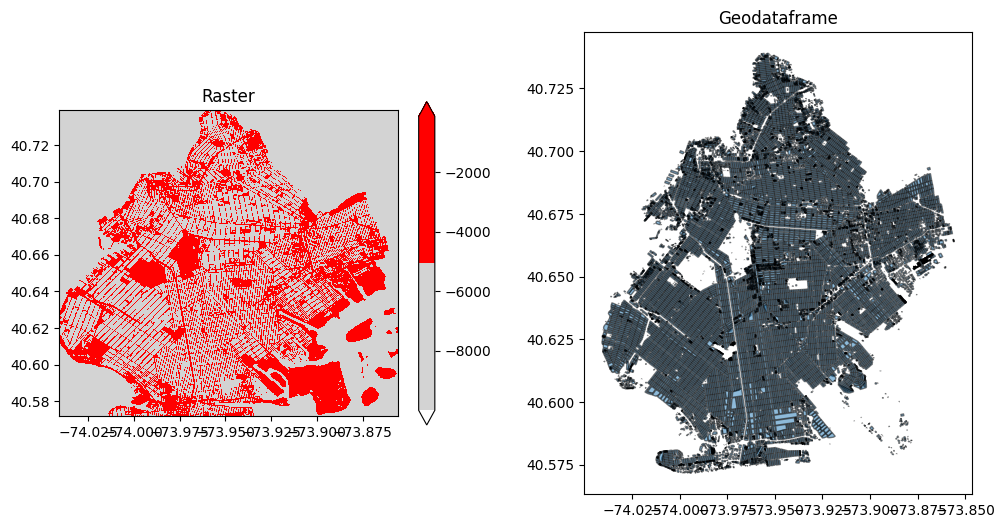

In [14]:
import matplotlib.colors as colors

# Define a color map for the raster
cmap = colors.ListedColormap(['lightgray', 'red'])
cmap.set_under(color='white')

# Plot the raster
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
raster_image = ax1.imshow(raster, cmap=cmap, vmin=-9999, vmax=-128, extent=[min_x, max_x, min_y, max_y])
ax1.set_title('Raster')

# Plot the geodataframe
building_gdf.plot(ax=ax2, alpha=0.5, edgecolor='k')
ax2.set_title('Geodataframe')

# Add a colorbar
fig.colorbar(raster_image, ax=ax1, extend='both', shrink=0.7)

# Show the plot
plt.show()

In [15]:
raster

array([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

In [16]:
raster.shape

(7378, 7592)

In [17]:
# x coordinates of the grid cells
grid_sizex = (max_x-min_x)/raster.shape[0]
grid_sizey = (max_y-min_y)/(raster.shape[1])


xgrid = np.arange(min_x, max_x, grid_sizex)
# y coordinates of the grid cells
ygrid = np.arange(min_y, max_y, grid_sizey)

X, Y = np.meshgrid(xgrid, ygrid[::-1])

In [18]:
raster.shape

(7378, 7592)

In [19]:
xgrid.shape

(7378,)

In [20]:
ygrid.shape

(7592,)

In [21]:
land_reference = raster
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.0

In [22]:
land_reference.shape

(7378, 7592)

In [23]:
land_mask.shape

(56013776,)

In [24]:
xy

array([[ 0.71102986, -1.29077276],
       [ 0.71102986, -1.29077232],
       [ 0.71102986, -1.29077188],
       ...,
       [ 0.70810916, -1.2904361 ],
       [ 0.70810916, -1.29043566],
       [ 0.70810916, -1.29043522]])

In [25]:
#train test split
from sklearn.model_selection import train_test_split
X_data = np.vstack([camera_locs['y'],camera_locs['x']]).T
y = np.array(camera_locs["Data_Source"] == "Amnesty", dtype=int)

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.90, random_state=123)
X_train *= np.pi / 180.0  # Convert lat/long to radians

In [26]:
X_train

array([[ 0.70866826, -1.29114074],
       [ 0.70926814, -1.29026914],
       [ 0.70946445, -1.28979541],
       ...,
       [ 0.70897543, -1.29131541],
       [ 0.70958535, -1.28934474],
       [ 0.70847814, -1.2906726 ]])

In [27]:
X_train.shape

(1065, 2)

In [28]:
y_train

array([1, 1, 0, ..., 0, 1, 1])

In [24]:
# kde = KernelDensity(bandwidth=0.04, metric="haversine", kernel="gaussian", algorithm="ball_tree")
# print('Defined KDE')
# kde.fit(X_train)
# print('Fit KDE')

# # evaluate only on the land: -9999 indicates ocean
# Z = np.full(land_mask.shape[0], -9999, dtype="int")
# Z[land_mask] = np.exp(kde.score_samples(xy))
# Z = Z.reshape(X.shape)
# print('Done evaluated only land area')
# # plot contours of the density
# levels = np.linspace(0, Z.max(), 25)
# plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

# # if basemap:
# #     print(" - plot coastlines using basemap")
# #     m = Basemap(
# #         projection="cyl",
# #         llcrnrlat=Y.min(),
# #         urcrnrlat=Y.max(),
# #         llcrnrlon=X.min(),
# #         urcrnrlon=X.max(),
# #         resolution="c",
# #     )
# #     m.drawcoastlines()
# #     m.drawcountries()
# # else:
# #     print(" - plot coastlines from coverage")
# plt.contour(
#     X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
# )
# plt.xticks([])
# plt.yticks([])

# # plt.title(species_names[i])

# plt.show()

In [36]:
kde = KernelDensity(bandwidth=0.0001, metric="haversine", kernel="gaussian", algorithm="ball_tree")

In [37]:
kde.fit(X_train)

KernelDensity(algorithm='ball_tree', bandwidth=0.0001, metric='haversine')

In [38]:
# evaluate only on the land: -9999 indicates ocean
Z = np.full(land_mask.shape[0], -9999, dtype="int")

In [39]:
Z[land_mask] = np.exp(kde.score_samples(xy))

In [40]:
Z = Z.reshape(X.shape)
print('Done evaluated only land area')

Done evaluated only land area


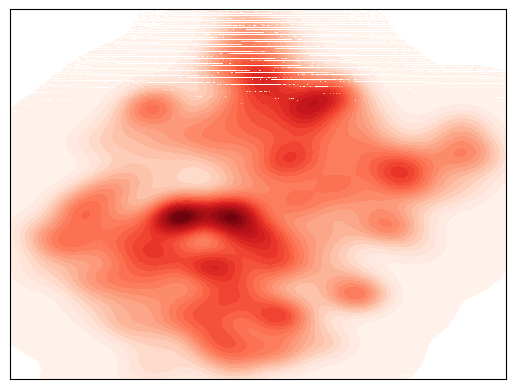

In [45]:
# plot contours of the density
levels = np.linspace(0, Z.max(), 25)
plt.contourf(X,Y,Z, levels=levels,cmap=plt.cm.Reds)
# plt.contour(Y,X, land_reference, levels=[-9998], colors="k", linestyles="solid")
plt.xticks([])
plt.yticks([])

# plt.title(species_names[i])

plt.show()

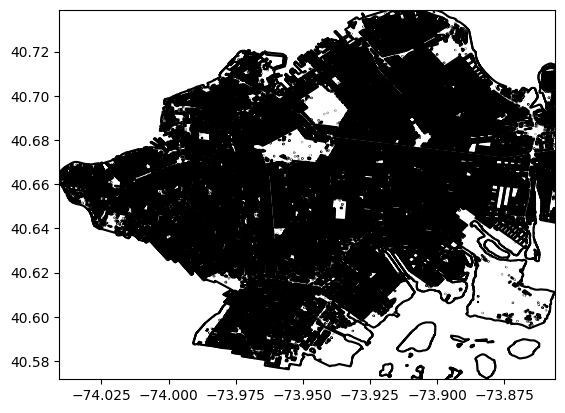

In [62]:
plt.contour(X,Y,land_reference.T, levels=[-9998], colors="k", linestyles="solid")

In [50]:
X.shape

(7592, 7378)

In [51]:
Y.shape

(7592, 7378)

In [53]:
land_reference.T.shape

(7592, 7378)